# Validation

In [19]:
# import libraries
import os
import ROOT
import numpy as np
from scipy import stats
from tableauColors import palette
from array import array

## 0. Helpers

In [2]:
# helpers
def leakageCorrection(col):
    return f"{col}*PrimaryEnergy/(PrimaryEnergy-LateralLeakage)"

def modifiedZscore(rdf, col, D=3.5):
    x = rdf.AsNumpy(columns=[col])[col]
    xtilde = np.median(x)
    MAD = np.median(np.abs(x-xtilde))
    return f"abs(0.6745*({col}-({xtilde}))/{MAD}) <= {D}"

In [3]:
cal = np.load("calibration.pkl.npy", allow_pickle=True).item()

## 1. Energy resolution as a fct of energy

In [4]:
# create rdataframe
path = "/groups/hep/mojen/repositories/DREAM/Run/final_run/range"
fileName = os.path.join(path, "range2.root")
rdf = ROOT.ROOT.RDataFrame("B4", os.path.join(path, fileName))
print(rdf.GetColumnNames())

{ "PrimaryPDG", "PrimaryEnergy", "PrimaryDecayMode", "LateralLeakage", "AbsorberMaterial", "VoxelsAlongY", "VecShowerPDG", "VecShowerCharge", "VecShowerPosition", "VecShowerEnergy", "VecShowerMomentum", "VecShowerCkovCoMi", "VecShowerCkovCoMj", "VecShowerScntCoMi", "VecShowerScntCoMj", "VecIndexCkov", "VecSignalCkov", "VecIndexScnt", "VecSignalScnt" }


In [5]:
rdf2 = rdf
rdf2 = rdf2.Define("Chi", f"{cal['chi']}")
rdf2 = rdf2.Define("VecSignalScnt_corr", leakageCorrection("VecSignalScnt"))
rdf2 = rdf2.Define("VecSignalCkov_corr", leakageCorrection("VecSignalCkov"))
rdf2 = rdf2.Define("VecSignalScnt_cal", f"VecSignalScnt*{cal['Scnt']}")
rdf2 = rdf2.Define("VecSignalCkov_cal", f"VecSignalCkov*{cal['Ckov']}")
rdf2 = rdf2.Define("Ssum", "Sum(VecSignalScnt_cal)")
rdf2 = rdf2.Define("Csum", "Sum(VecSignalCkov_cal)")
rdf2 = rdf2.Define("Snorm", f"Ssum / PrimaryEnergy")
rdf2 = rdf2.Define("Cnorm", f"Csum / PrimaryEnergy")
rdf2 = rdf2.Define("CoverS", "Cnorm/Snorm")
rdf2 = rdf2.Define("PrimaryEnergy_GeV", "PrimaryEnergy / 1000.")
rdf2_e = rdf2.Filter("PrimaryPDG == 11", "electron")
rdf2_pi = rdf2.Filter("PrimaryPDG == -211", "pion")
rdf2_e = rdf2_e.Define("rec_energy", f"(Ssum+Csum)/2")
rdf2_pi = rdf2_pi.Define("rec_energy", f"(Ssum-Chi*Csum)/(1-Chi)")
rdf2_e = rdf2_e.Define("rmse", "abs(PrimaryEnergy-rec_energy)/PrimaryEnergy")
rdf2_pi = rdf2_pi.Define("rmse", "abs(PrimaryEnergy-rec_energy)/PrimaryEnergy")

# print cuts report
cutsReport_e = rdf2_e.Report()
cutsReport_e.Print()
cutsReport_pi = rdf2_pi.Report()
cutsReport_pi.Print()

electron  : pass=10000      all=20000      -- eff=50.00 % cumulative eff=50.00 %
pion      : pass=10000      all=20000      -- eff=50.00 % cumulative eff=50.00 %


electron  : pass=10000      all=20000      -- eff=50.00 % cumulative eff=50.00 %
10.00051099891 GeV: pass=1000       all=10000      -- eff=10.00 % cumulative eff=5.00 %
modified Z-score: pass=997        all=1000       -- eff=99.70 % cumulative eff=4.99 %
 FCN=85.6227 FROM MIGRAD    STATUS=CONVERGED      69 CALLS          70 TOTAL
                     EDM=3.03724e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.60488e+01   1.54074e+00   5.42659e-03   1.62290e-07
   2  Mean         1.00064e+04   1.02733e+01   4.66632e-02   7.56251e-07
   3  Sigma        3.04484e+02   8.51950e+00   3.18007e-05  -8.10403e-05
electron  : pass=10000      all=20000      -- eff=50.00 % cumulative eff=50.00 %
20.00051099891 GeV: pass=1000       all=10000      -- eff=10.00 % cumulative eff=5.00 %
modified Z-score: pass=996        all=1000       -- eff=

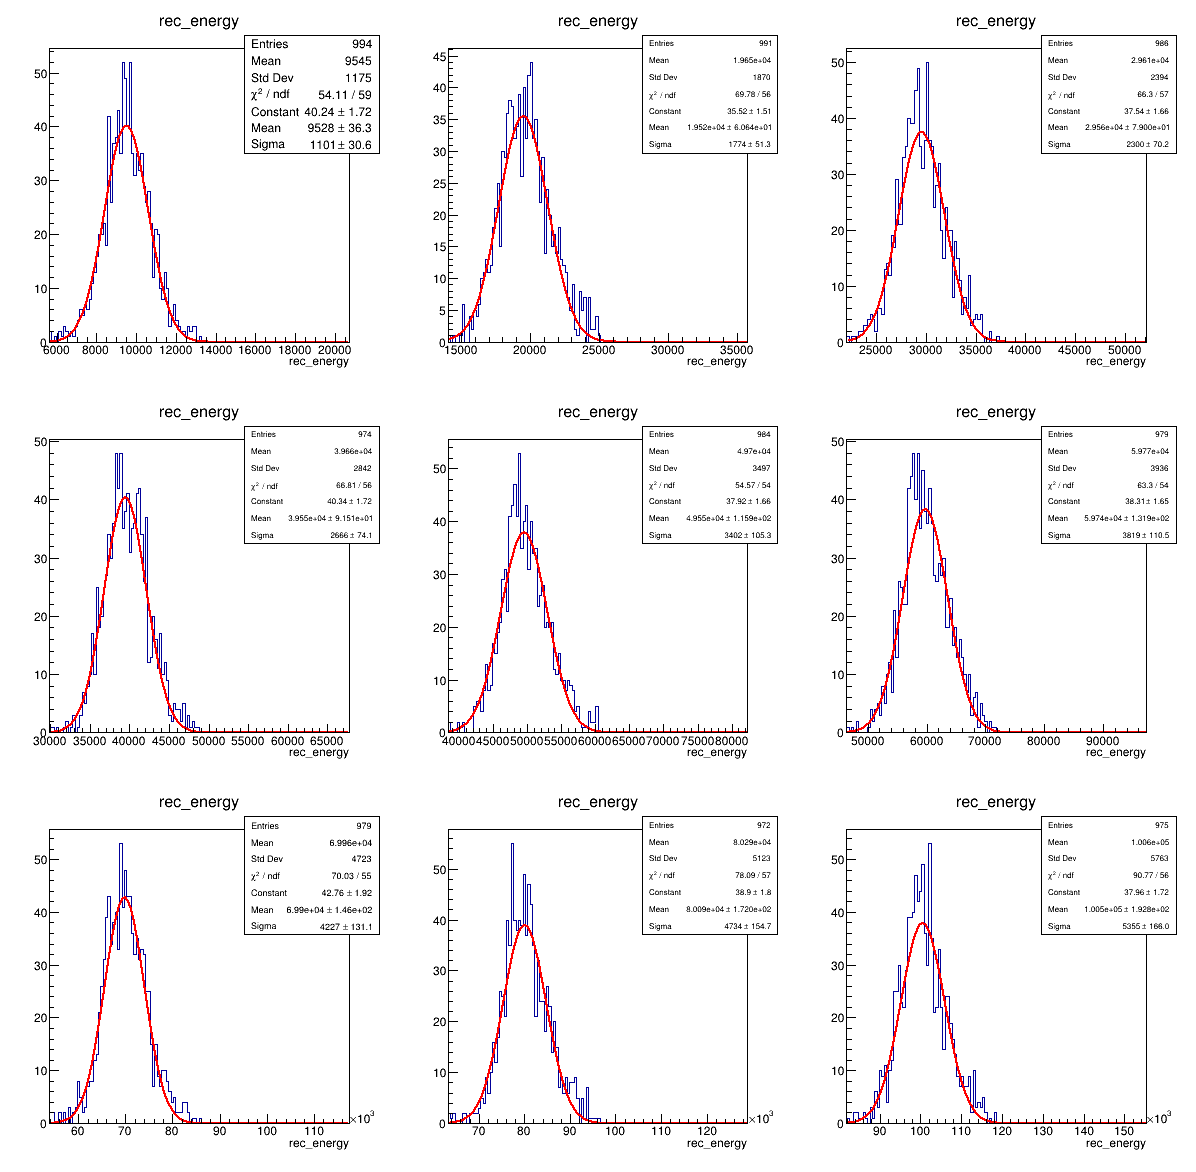

In [79]:
import copy
ROOT.gStyle.SetOptStat("emr")
d = {k: np.zeros(10) for k in ['Energy', 'EnergyRes', 'EnergyResErr']}
data = {'e': copy.deepcopy(d), 'pi': copy.deepcopy(d)}
for rdf,s in zip([rdf2_e, rdf2_pi], ['e', 'pi']):
    c1 = ROOT.TCanvas("c1", "c1", 1200, 1200)
    c1.Divide(3,3)
    unique_energies = np.unique(rdf.AsNumpy(columns=['PrimaryEnergy'])['PrimaryEnergy'])
    for i,e in enumerate(unique_energies):
        c1.cd(i+1)
        rdf3 = rdf.Filter(f"PrimaryEnergy == {e}", f"{e*1e-3} GeV")
        rdf3 = rdf3.Filter(modifiedZscore(rdf3, "rec_energy"), "modified Z-score")
        cutsReport = rdf3.Report()
        cutsReport.Print()
        h = rdf3.Histo1D('rec_energy')
        r = h.Fit("gaus", "S")
        data[s]['Energy'][i] = e*1e-3
        data[s]['EnergyRes'][i] = r.Parameter(2)/r.Parameter(1)*1e2
        data[s]['EnergyResErr'][i] = data[s]['EnergyRes'][i]*(r.ParError(1)/r.Parameter(1)+r.ParError(2)/r.Parameter(2))
        h.DrawCopy()
    c1.Draw()

1.0
1.0
1.0
pion      : pass=10000      all=20000      -- eff=50.00 % cumulative eff=50.00 %
80 GeV    : pass=1000       all=10000      -- eff=10.00 % cumulative eff=5.00 %
 FCN=30.9598 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=6.56462e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     7.39224e+01   3.13732e+00   6.64067e-03  -9.65967e-05
   2  Mean         7.13819e+01   1.68497e-01   4.63047e-04  -1.64281e-03
   3  Sigma        5.10581e+00   1.41725e-01   1.91831e-05  -2.34758e-02
 FCN=64.1835 FROM MIGRAD    STATUS=CONVERGED      65 CALLS          66 TOTAL
                     EDM=2.36704e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  

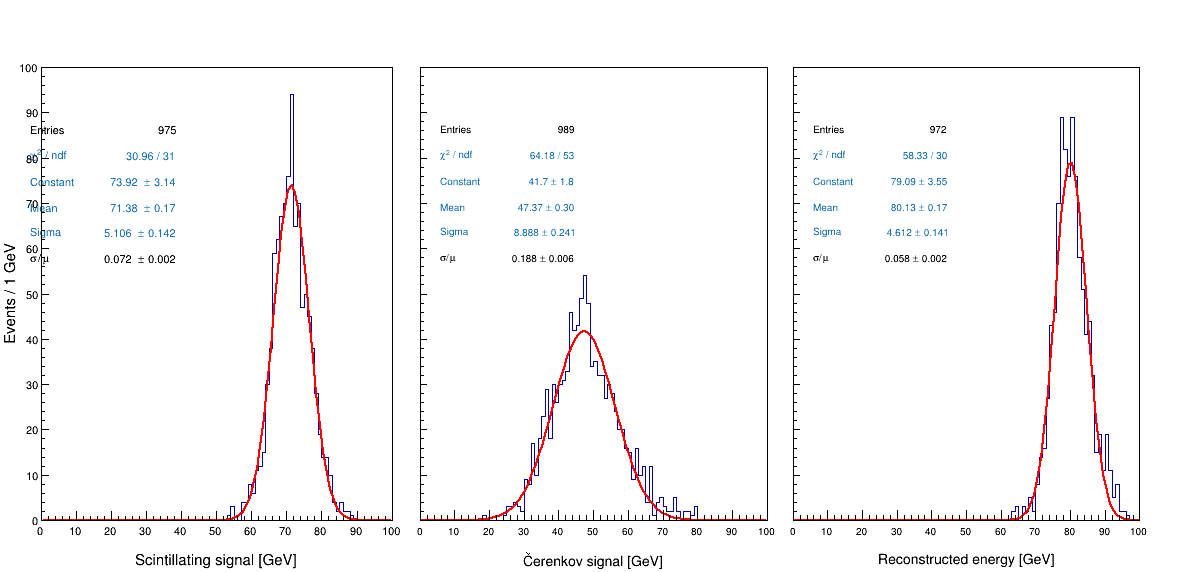

In [213]:
ROOT.gStyle.SetOptStat("e")
c3 = ROOT.TCanvas("c3", "c3", 1200, 600)
c3.Divide(3, 1, 0, 0)
h = [None, None, None]
r = h.copy()

labelsize = 0.03
titlesize = 0.04
titleoffset = 1.2
labeloffset = 0.005
linewidth = 3
ticklength = 0.02

for rdf,s in zip([rdf2_pi], ['pi']):
    rdf2_e80 = rdf.Filter("std::round(PrimaryEnergy*1E-3) == 80", "80 GeV")
    cutsReport = rdf2_e80.Report()
    cutsReport.Print()
    colname = ["Scintillating signal", "#check{C}erenkov signal", "Reconstructed energy"]
    for i,col in enumerate(['Ssum', 'Csum', 'rec_energy']):
        c3.cd(i+1)
        new_col = col + "_GeV"
        rdf2_e80 = rdf2_e80.Define(new_col, f"{col}*1e-3")
        rdf2_e80_ = rdf2_e80.Filter(modifiedZscore(rdf2_e80, new_col), "modified Z-score")
        model = ("", "", 100, 0., 100.)
        h[i] = rdf2_e80_.Histo1D(model, new_col)
        r[i] = h[i].Fit("gaus", "S")
        
        h[i].GetXaxis().SetTitle(colname[i] + " [GeV]")
        h[i].SetAxisRange(0., 100., "Y")
        h[i].GetXaxis().SetTickLength(ticklength)
        h[i].GetYaxis().SetTickLength(ticklength)
        h[i].GetXaxis().SetTitleSize(titlesize)
        h[i].GetYaxis().SetTitleSize(titlesize)
        h[i].GetXaxis().SetLabelSize(labelsize)
        h[i].GetYaxis().SetLabelSize(labelsize)
        h[i].GetXaxis().CenterTitle()
        h[i].GetXaxis().SetTitleOffset(titleoffset)
        h[i].GetXaxis().SetLabelOffset(labeloffset)
        
        ROOT.gPad.SetRightMargin(.05)
        ROOT.gPad.SetTopMargin(.02)

        if i == 0:
            h[i].GetYaxis().SetTitle(f"Events / {h[i].GetBinWidth(0):.1g} GeV")
            h[i].GetYaxis().CenterTitle()
            h[i].GetYaxis().SetTitleOffset(titleoffset)
            h[i].GetYaxis().SetLabelOffset(labeloffset)
        else:
            h[i].GetYaxis().SetLabelOffset(999)
            h[i].GetYaxis().SetLabelSize(0)
            ROOT.gPad.SetLeftMargin(.02)
        
        print(ROOT.gPad.GetAbsWNDC())
        
        h[i].Draw()
        
        c3.Update()
        
        stats1 = ROOT.gPad.GetPrimitive("stats")
        stats1.SetName("stats1")
        listOfLines1 = stats1.GetListOfLines()
        
        res = r[i].Parameter(2)/r[i].Parameter(1)
        reserr = res*(r[i].ParError(1)/r[i].Parameter(1)+r[i].ParError(2)/r[i].Parameter(2))
        
        myt1 = ROOT.TLatex(0, 0, f"#sigma/#mu = {res:.3f} #pm {reserr:.3f}")
        myt1.SetTextSize(labelsize)
        myt1.SetTextFont(42)
        myt1.SetTextColor(ROOT.kBlack)
        listOfLines1.First().SetTextColor(ROOT.kBlack)
        listOfLines1.Add(myt1)
        stats1.SetTextColor(palette['blue'].GetNumber())
        stats1.SetX1NDC(c3.GetLeftMargin()+ticklength); stats1.SetX2NDC(stats1.GetX1NDC()+0.4)
        stats1.SetY2NDC(1-c3.GetTopMargin()-0.016); stats1.SetY1NDC(stats1.GetY2NDC()-0.3)
        stats1.SetTextSize(labelsize)
        stats1.SetBorderSize(0)
        h[i].SetStats(0)
        
c3.Draw()

data['e']['EnergyResErr'], data['pi']['EnergyResErr']

 FCN=7.3744 FROM MIGRAD    STATUS=CONVERGED      36 CALLS          37 TOTAL
                     EDM=1.86746e-20    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           8.43357e+00   3.31837e-01   1.46194e-04  -6.68286e-10
   2  p1           3.93725e-01   4.76804e-02   2.10061e-05  -6.34230e-10
 FCN=5.7512 FROM MIGRAD    STATUS=CONVERGED      36 CALLS          37 TOTAL
                     EDM=1.12168e-21    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.83727e+01   1.46199e+00   5.92085e-04  -9.37553e-11
   2  p1           2.62884e+00   2.11803e-01   8.57770e-05  -6.98929e-10


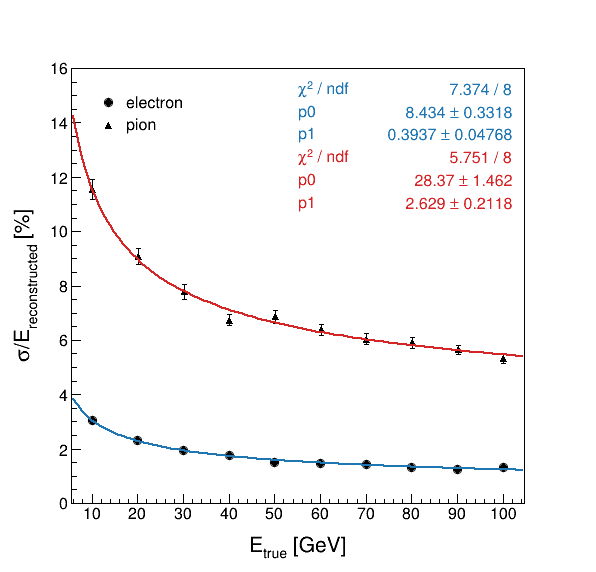

In [109]:
ROOT.gStyle.SetOptStat("emr")
ROOT.gStyle.SetOptFit(1)

c2 = ROOT.TCanvas("c2", "c2", 600, 600)
c2.SetLeftMargin(.12)
c2.SetBottomMargin(.12)
c2.SetRightMargin(.12)
c2.SetTopMargin(.12)

mg = ROOT.TMultiGraph()
gr = [None, None]
f1 = [None, None]
f1[0] = ROOT.TF1("f1","[0]/sqrt(x)+[1]")
f1[1] = f1[0].Clone()
f1[0].SetLineColor(palette['blue'].GetNumber())
f1[1].SetLineColor(palette['red'].GetNumber())
marker = [ROOT.kFullDotLarge, ROOT.kFullTriangleUp]


for i,s in enumerate(['e', 'pi']):
    x = array('f', data[s]['Energy'])
    n = len(x)
    y = array('f', data[s]['EnergyRes'])
    ex = array('f', [0.]*n)
    ey = array('f', data[s]['EnergyResErr'])
    gr[i] = ROOT.TGraphErrors(n, x, y, ex, ey)
    gr[i].Fit(f1[i], "S")
    gr[i].SetMarkerStyle(marker[i])
    
    mg.Add(gr[i])
mg.Draw('ap')

c2.Update()

labelsize = 0.03
titlesize = 0.04
titleoffset = 1.2
labeloffset = 0.005
linewidth = 3
ticklength = 0.02

mg.GetXaxis().SetTitle("E_{true} [GeV]")
mg.GetYaxis().SetTitle("#sigma/E_{reconstructed} [%]")
mg.SetMinimum(0.)
mg.SetMaximum(16.)
mg.GetXaxis().SetTickLength(ticklength)
mg.GetYaxis().SetTickLength(ticklength)
mg.GetXaxis().SetTitleSize(titlesize)
mg.GetYaxis().SetTitleSize(titlesize)
mg.GetXaxis().SetLabelSize(labelsize)
mg.GetYaxis().SetLabelSize(labelsize)
mg.GetXaxis().CenterTitle()
mg.GetYaxis().CenterTitle()
mg.GetXaxis().SetTitleOffset(titleoffset)
mg.GetYaxis().SetTitleOffset(titleoffset)
mg.GetXaxis().SetLabelOffset(labeloffset)
mg.GetYaxis().SetLabelOffset(labeloffset)

stats1 = gr[0].GetListOfFunctions().FindObject("stats")
stats2 = gr[1].GetListOfFunctions().FindObject("stats")
stats1.SetTextColor(palette['blue'].GetNumber())
stats2.SetTextColor(palette['red'].GetNumber())
stats1.SetX2NDC(1-c2.GetRightMargin()); stats1.SetX1NDC(stats1.GetX2NDC()-0.4)
stats1.SetY2NDC(1-c2.GetTopMargin()-0.016); stats1.SetY1NDC(stats1.GetY2NDC()-0.12)
stats2.SetX2NDC(stats1.GetX2NDC()); stats2.SetX1NDC(stats1.GetX1NDC())
stats2.SetY2NDC(stats1.GetY1NDC()); stats2.SetY1NDC(stats2.GetY2NDC()-0.12)
stats1.SetTextSize(labelsize)
stats2.SetTextSize(labelsize)
stats1.SetBorderSize(0)
stats2.SetBorderSize(0)

# add legend
x1 = c2.GetLeftMargin() + 0.03
x2 = x1 + 0.25
y2 = 1 - c2.GetTopMargin() - 0.03 - 0.01
y1 = y2 - 0.08
legend = ROOT.TLegend(x1, y1, x2, y2)
legend.SetFillColor(0)
legend.SetBorderSize(0)
legend.SetTextSize(labelsize)
legend.AddEntry(gr[0], "electron", "p")
legend.AddEntry(gr[1], "pion", "p")
legend.Draw()

c2.Modified()
c2.Print("energyres.png")
c2.Draw()

## 2. Example for 80 GeV

In [4]:
# create rdataframe
path = "/groups/hep/mojen/repositories/DREAM/Run/final_run/range"
fileName = os.path.join(path, "range.root")
rdf = ROOT.ROOT.RDataFrame("B4", os.path.join(path, fileName))
print(rdf.GetColumnNames())

{ "PrimaryPDG", "PrimaryEnergy", "PrimaryDecayMode", "LateralLeakage", "AbsorberMaterial", "VoxelsAlongY", "VecShowerPDG", "VecShowerCharge", "VecShowerPosition", "VecShowerEnergy", "VecShowerMomentum", "VecShowerCkovCoMi", "VecShowerCkovCoMj", "VecShowerScntCoMi", "VecShowerScntCoMj", "VecIndexCkov", "VecSignalCkov", "VecIndexScnt", "VecSignalScnt" }


## 1. Performance

### Energy resolution

In [22]:
rdf2 = rdf
# rdf2 = rdf2.Filter("( > 10000) && (VecShowerEnergy.at(0)) < 25000")
rdf2 = rdf2.Define("Chi", f"{cal['chi']}")
rdf2 = rdf2.Define("VecSignalScnt_corr", leakageCorrection("VecSignalScnt"))
rdf2 = rdf2.Define("VecSignalCkov_corr", leakageCorrection("VecSignalCkov"))
rdf2 = rdf2.Define("VecSignalScnt_cal", f"VecSignalScnt*{cal['Scnt']}")
rdf2 = rdf2.Define("VecSignalCkov_cal", f"VecSignalCkov*{cal['Ckov']}")
rdf2 = rdf2.Define("Ssum", "Sum(VecSignalScnt_cal)")
rdf2 = rdf2.Define("Csum", "Sum(VecSignalCkov_cal)")
rdf2 = rdf2.Define("Snorm", f"Ssum / PrimaryEnergy")
rdf2 = rdf2.Define("Cnorm", f"Csum / PrimaryEnergy")
rdf2 = rdf2.Define("CoverS", "Cnorm/Snorm")
rdf2 = rdf2.Define("PrimaryEnergy_GeV", "PrimaryEnergy / 1000.")
rdf2_e = rdf2.Filter("PrimaryPDG == 11", "electron")
rdf2_pi = rdf2.Filter("PrimaryPDG == -211", "pion")
rdf2_e = rdf2_e.Define("reconstructed_energy", f"(Ssum+Csum)/2")
rdf2_pi = rdf2_pi.Define("reconstructed_energy", f"(Ssum-Chi*Csum)/(1-Chi)")
rdf2_e = rdf2_e.Define("rmse", "sqrt(pow(PrimaryEnergy-reconstructed_energy, 2))/PrimaryEnergy*100")
rdf2_pi = rdf2_pi.Define("rmse", "sqrt(pow(PrimaryEnergy-reconstructed_energy, 2))/PrimaryEnergy*100")

# print cuts report
# cutsReport = rdf_energy_pi.Report()
# cutsReport.Print()

### C/E vs. S/E

In [8]:
rdf3_e = rdf2_e
rdf3_pi = rdf2_pi
# rdf3_e = rdf2_e.Filter("PrimaryEnergy > 15000 && PrimaryEnergy < 25000")
# rdf3_pi = rdf2_pi.Filter("PrimaryEnergy > 15000 && PrimaryEnergy < 25000")
# modified Z score
#rdf3_e = rdf3_e.Filter(modifiedZscore(rdf3_e, "Snorm")+"&&"+modifiedZscore(rdf3_e, "Cnorm"), "Cut2")
#rdf3_pi = rdf3_pi.Filter(modifiedZscore(rdf3_pi, "Snorm")+"&&"+modifiedZscore(rdf3_pi, "Cnorm"), "Cut2")

In [9]:
# correlation coefficients
SC_e = rdf3_e.AsNumpy(columns=["Snorm", "Cnorm"])
SC_pi = rdf3_pi.AsNumpy(columns=["Snorm", "Cnorm"])
print(stats.pearsonr(x=SC_e['Snorm'], y=SC_e['Cnorm']))
print(stats.pearsonr(x=SC_pi['Snorm'], y=SC_pi['Cnorm']))

(-0.09960651396945631, 2.7518591794235755e-21)
(0.7315351882157909, 0.0)


In [10]:
# rotation method
gr = rdf3_pi.Graph("Snorm", "Cnorm")
# linear fit
r = gr.Fit("pol1", "S")


****************************************
Minimizer is Linear
Chi2                      =      84.2695
NDf                       =         8998
p0                        =    -0.321605   +/-   0.00878572  
p1                        =      1.02539   +/-   0.0100749   


In [11]:
p0 = r.Parameter(0)
p1 = r.Parameter(1)
X = p0/(1-p1)
theta = np.pi/2 - np.arctan(p1)
print(p0, p1, X, theta*180/np.pi)

-0.3216053373453362 1.0253873037455836 12.66795956625692 44.28186121074958


In [12]:
rotate_xcoord_code = '''
double rotate_xcoord(double x, double y, double angle, double cx) {
    double s = sin(angle);
    double c = cos(angle);
    x -= cx;
    y -= cx;
    double xnew = x * c - y * s;
    double ynew = x * s + y * c;
    x = xnew + cx;
    y = ynew + cx;
    return x;
};
'''
ROOT.gInterpreter.Declare(rotate_xcoord_code)
rotate_ycoord_code = '''
double rotate_ycoord(double x, double y, double angle, double cx) {
    double s = sin(angle);
    double c = cos(angle);
    x -= cx;
    y -= cx;
    double xnew = x * c - y * s;
    double ynew = x * s + y * c;
    x = xnew + cx;
    y = ynew + cx;
    return y;
};
'''
ROOT.gInterpreter.Declare(rotate_ycoord_code)

True

In [13]:
rdf3_pi = rdf3_pi.Define("PivotPoint", str(X))
rdf3_pi = rdf3_pi.Define("PivotAngle", str(theta))
rdf3_pi = rdf3_pi.Define("Snorm_rot", "rotate_xcoord(Snorm, Cnorm, PivotAngle, PivotPoint)")
rdf3_pi = rdf3_pi.Define("Cnorm_rot", "rotate_ycoord(Snorm, Cnorm, PivotAngle, PivotPoint)")

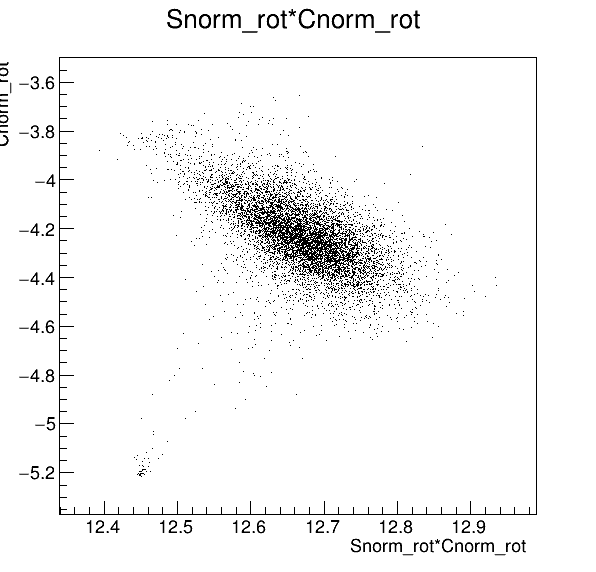

In [14]:
c1 = ROOT.TCanvas("c1", "c1", 600, 600)
gr = rdf3_pi.Graph("Snorm_rot", "Cnorm_rot")
gr.Draw("ap")
c1.Draw()

 FCN=179.996 FROM MIGRAD    STATUS=CONVERGED      71 CALLS          72 TOTAL
                     EDM=3.74333e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.66481e+02   6.46948e+00   3.26300e-02  -6.92965e-06
   2  Mean         1.26699e+01   6.92201e-04   6.04147e-06   1.67639e-01
   3  Sigma        6.38815e-02   5.68680e-04   1.43670e-05  -8.83533e-02


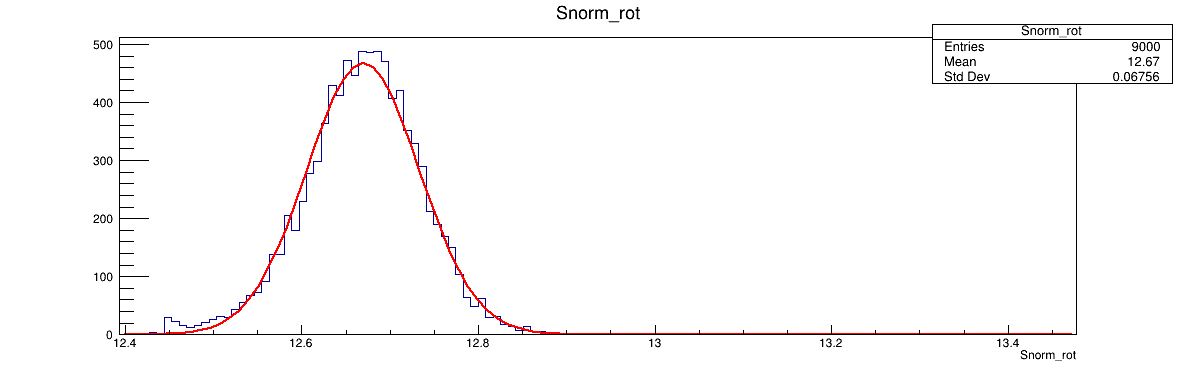

In [15]:
c5 = ROOT.TCanvas("c5", "c5", 1200, 400)
h5c = rdf3_pi.Histo1D("Snorm_rot")
h5c.Draw()
rc = h5c.Fit("gaus", "S")
c5.Draw()

In [16]:
# rdf3_e = rdf3_e.Define("reconstructed_energy", f"(Snorm+Cnorm)/2")
# rdf3_pi = rdf3_pi.Define("reconstructed_energy", f"(Snorm-Chi*Cnorm)/(1-Chi)")
# rdf3_e = rdf3_e.Define("reconstructed_energy", f"(Sum(VecSignalScnt_cal)-Chi*Sum(VecSignalCkov_cal))/(1-Chi)")
# rdf3_pi = rdf3_pi.Define("reconstructed_energy", f"(Sum(VecSignalScnt_cal)-Chi*Sum(VecSignalCkov_cal))/(1-Chi)")

 FCN=1376.92 FROM MIGRAD    STATUS=CONVERGED      74 CALLS          75 TOTAL
                     EDM=6.18247e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.30544e+02   3.00219e+00   4.78606e-02  -5.43256e-06
   2  Mean         4.80383e+04   2.89136e+02   4.98028e+00   1.12983e-07
   3  Sigma        2.24330e+04   1.62886e+02   3.57822e-05   2.98830e-03


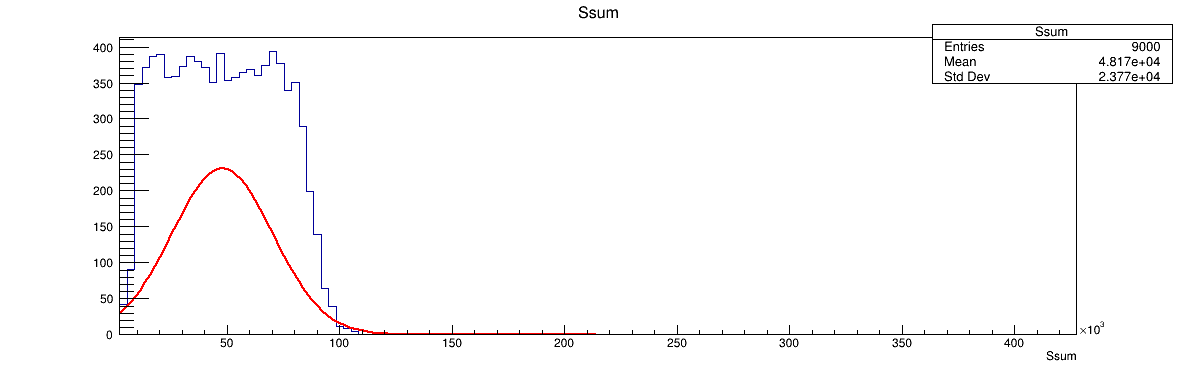

In [17]:
c5 = ROOT.TCanvas("c5", "c5", 1200, 400)
h5c = rdf3_pi.Histo1D("Ssum")
h5c.Draw()
rc = h5c.Fit("gaus", "S")
c5.Draw()

In [18]:
# C/E vs S/E
gr1 = rdf3_e.Graph("Snorm", "Cnorm")
gr2 = rdf3_pi.Graph("Snorm", "Cnorm")
gr1.SetMarkerColor(palette['blue'].GetNumber())
gr2.SetMarkerColor(palette['red'].GetNumber())
gr1.SetMarkerStyle(ROOT.kFullDotSmall)
gr2.SetMarkerStyle(ROOT.kFullDotSmall)

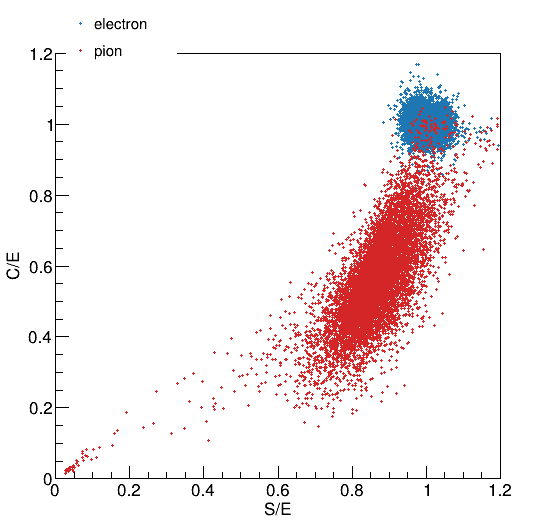

In [19]:
ratio = 7/3
nbins = 40
c1 = ROOT.TCanvas("c1", "c1", 560, 560)
# c1.SetRightMargin(0.)
# c1.SetTopMargin(0.)
mg = ROOT.TMultiGraph()
mg.Add(gr1.GetPtr())
mg.Add(gr2.GetPtr())
mg.Draw("ap")
mg.GetXaxis().SetTitle("S/E")
mg.GetYaxis().SetTitle("C/E")
mg.GetXaxis().CenterTitle()
mg.GetYaxis().CenterTitle()
mg.SetMinimum(0)
mg.SetMaximum(1.2)
mg.GetXaxis().SetLimits(0, 1.2)

# 
labelsize = 1.2 * mg.GetYaxis().GetLabelSize()
titlesize = 1.4 * mg.GetYaxis().GetTitleSize()
xtitleoffset = 1.2 * mg.GetXaxis().GetTitleOffset()
ytitleoffset = 0.9 * xtitleoffset
xlabeloffset = 2 * mg.GetXaxis().GetLabelOffset()
ylabeloffset = 1.5 * mg.GetYaxis().GetLabelOffset()
linewidth = 2
ticklength = 0.02

# add legend
legend = ROOT.TLegend(0.12, 0.88, 0.32, 0.98)
legend.SetFillColor(0)
legend.SetBorderSize(0)
legend.SetTextSize(0.03)
legend.AddEntry(gr1.GetValue(), "electron", "p")
legend.AddEntry(gr2.GetValue(), "pion", "p")
legend.Draw()
c1.Draw()
c1.Print("hXY.png")

## Energy resolution

In [7]:
c2 = ROOT.TCanvas("c1", "c1", 1000, 600)
c2.Divide(3)
ROOT.gStyle.SetOptStat("mr")
modelX = ("", "", 70, 0., 1.4)
h_e = [None, None, None]
h_pi = [None, None, None]
for i,col in enumerate(['Snorm', 'Cnorm', 'reconstructed_energy']):
    c2.cd(i+1)
    h_e[i] = rdf2_e.Histo1D(modelX, col)
    h_pi[i] = rdf2_pi.Histo1D(modelX, col)
    h_e[i].SetLineColor(palette['blue'].GetNumber())
    h_pi[i].SetLineColor(palette['red'].GetNumber())
    # 
    r = h_pi[i].Fit("gaus", "S")
#     hX.SetStats(False)

    h_e[i].SetLineWidth(linewidth)
    h_pi[i].SetLineWidth(linewidth)

    h_e[i].Draw()
    h_pi[i].Draw("sames")
    
    if i == 0:
        h_e[i].GetYaxis().SetTitle(f"Events / {h_e[i].GetBinWidth(1)}")
        h_e[i].GetYaxis().CenterTitle()
    else:
        h_e[i].GetYaxis().SetLabelOffset(999)
        h_e[i].GetYaxis().SetLabelSize(0)

#     ROOT.gPad.SetLeftMargin(0.05)
    ROOT.gPad.SetRightMargin(0.02)
        
    c2.Update()

    # stat box
#     stats1 = hX_e.GetListOfFunctions().FindObject("stats")
#     hX_e.GetListOfFunctions().Remove(stats1)
#     hX_e.SetStats(0)
#     stats1.SetTextColor(palette['blue'].GetNumber())

#     stats1.SetX1NDC(0.1+2*ticklength)
#     stats1.SetY2NDC(1-2*ticklength)
#     stats1.SetX2NDC(stats1.GetX1NDC()+0.3)
#     stats1.SetY1NDC(stats1.GetY2NDC()-0.1*520/280)
#     stats1.SetTextSize(labelsize*520/280)
#     stats1.SetBorderSize(0)
#     stats1.GetListOfLines().Remove(stats1.GetLineWith("Mean y"))
#     stats1.Draw()
#     hX_e.SetStats(0)

#     stats2 = hX_pi.GetListOfFunctions().FindObject("stats")
#     hX_pi.GetListOfFunctions().Remove(stats2)
#     hX_pi.SetStats(0)
#     stats2.SetTextColor(palette['red'].GetNumber())
#     stats2.SetX2NDC(stats1.GetX2NDC())
#     stats2.SetY2NDC(stats1.GetY1NDC())
#     stats2.SetX1NDC(stats1.GetX1NDC())
#     stats2.SetY1NDC(stats1.GetY1NDC()-0.1*520/280)
#     stats2.SetTextSize(labelsize*520/280)
#     stats2.SetBorderSize(0)
#     stats2.Draw()
#     hX_pi.SetStats(0)

    h_e[i].SetAxisRange(0., 400., "Y")

c2.Draw()
c2.Print("hX.png")

NameError: name 'linewidth' is not defined

 FCN=325.677 FROM MIGRAD    STATUS=CONVERGED      94 CALLS          95 TOTAL
                     EDM=9.19682e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.00731e+03   1.38807e+01   9.03822e-02   2.40411e-06
   2  Mean         8.71941e-01   7.83880e-04   6.87703e-06   3.95362e-02
   3  Sigma        7.66315e-02   7.12893e-04   1.69307e-05   3.46434e-03


### Particle identification

In [7]:
# create rdataframe
path = "/groups/hep/mojen/repositories/DREAM/Run/final_run/pid"
rdf = {}
for x in ['electron', 'proton']:
    fileName = os.path.join(path, f"{x}/{x}.root")
    rdf[x] = ROOT.ROOT.RDataFrame("B4", os.path.join(path, fileName))
    rdf[x] = rdf[x].Define("VecSignalScnt_corr", leakageCorrection("VecSignalScnt"))
    rdf[x] = rdf[x].Define("VecSignalCkov_corr", leakageCorrection("VecSignalCkov"))
    rdf[x] = rdf[x].Define("VecSignalScnt_cal", f"VecSignalScnt*{cal['Scnt']}")
    rdf[x] = rdf[x].Define("VecSignalCkov_cal", f"VecSignalCkov*{cal['Ckov']}")
    rdf[x] = rdf[x].Define("Ssum", "Sum(VecSignalScnt_cal)")
    rdf[x] = rdf[x].Define("Csum", "Sum(VecSignalCkov_cal)")
    rdf[x] = rdf[x].Define("Snorm", f"Ssum / PrimaryEnergy")
    rdf[x] = rdf[x].Define("Cnorm", f"Csum / PrimaryEnergy")
    rdf[x] = rdf[x].Define("CoverS", "Cnorm/Snorm")

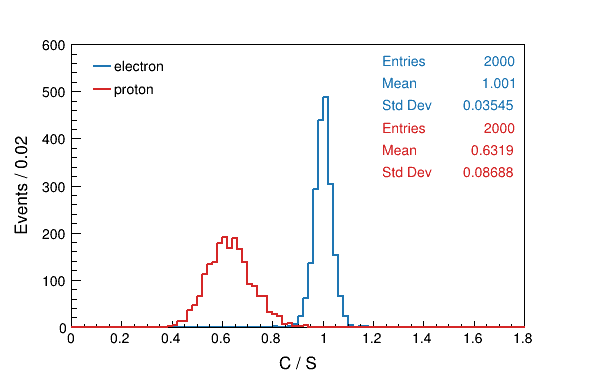

In [16]:
c6 = ROOT.TCanvas("c6", "c6", 600, 400)
ROOT.gPad.SetLeftMargin(0.12)
ROOT.gPad.SetBottomMargin(0.12)
ROOT.gPad.SetRightMargin(0.12)
ROOT.gPad.SetTopMargin(0.12)
ROOT.gStyle.SetOptStat("emr")

model = ("","", 90, 0., 1.8)
h6_e = rdf['electron'].Histo1D(model, "CoverS")
h6_pi = rdf['proton'].Histo1D(model, "CoverS")
h6_e.SetLineColor(palette['blue'].GetNumber())
h6_pi.SetLineColor(palette['red'].GetNumber())
h6_e.Draw()
h6_pi.Draw("sames")

labelsize = 1.2 * h6_e.GetYaxis().GetLabelSize()
titlesize = 1.4 * h6_e.GetYaxis().GetTitleSize()
xtitleoffset = 1.2 * h6_e.GetXaxis().GetTitleOffset()
ytitleoffset = 0.9 * xtitleoffset
xlabeloffset = 2 * h6_e.GetXaxis().GetLabelOffset()
ylabeloffset = 1.5 * h6_e.GetYaxis().GetLabelOffset()
linewidth = 2
ticklength = 0.02
x2ndc = 1-0.12
y2ndc = 1-0.12-0.012

h6_e.GetXaxis().SetTitle("C / S")
h6_e.GetXaxis().SetTitleSize(titlesize)
h6_e.GetXaxis().SetLabelSize(labelsize)
h6_e.GetXaxis().SetLabelOffset(xlabeloffset)
h6_e.GetXaxis().CenterTitle()
h6_e.GetXaxis().SetTitleOffset(xtitleoffset)
h6_e.GetXaxis().SetTickLength(ticklength)
binwidth = h6_e.GetBinWidth(1)
h6_e.SetAxisRange(0., 600., "Y")
h6_e.GetYaxis().SetTitle(f"Events / {binwidth}")
h6_e.GetYaxis().SetTitleSize(titlesize)
h6_e.GetYaxis().SetLabelSize(labelsize)
h6_e.GetYaxis().SetLabelOffset(ylabeloffset)
h6_e.GetYaxis().CenterTitle()
h6_e.GetYaxis().SetTitleOffset(ytitleoffset)
h6_e.GetYaxis().SetTickLength(ticklength)

h6_e.SetLineWidth(linewidth)
h6_pi.SetLineWidth(linewidth)

c6.Update()

# stat box
stats1 = h6_e.GetListOfFunctions().FindObject("stats")
h6_e.GetListOfFunctions().Remove(stats1)
h6_e.SetStats(0)
stats1.SetTextColor(palette['blue'].GetNumber())

stats1.SetX2NDC(x2ndc)
stats1.SetY2NDC(y2ndc)
stats1.SetX1NDC(stats1.GetX2NDC()-0.25)
stats1.SetY1NDC(stats1.GetY2NDC()-0.12*6/4)
stats1.SetTextSize(labelsize)
stats1.SetBorderSize(0)
stats1.GetListOfLines().Remove(stats1.GetLineWith("Mean y"))
stats1.Draw()
h6_e.SetStats(0)

stats2 = h6_pi.GetListOfFunctions().FindObject("stats")
h6_pi.GetListOfFunctions().Remove(stats2)
h6_pi.SetStats(0)
stats2.SetTextColor(palette['red'].GetNumber())
stats2.SetX2NDC(stats1.GetX2NDC())
stats2.SetY2NDC(stats1.GetY1NDC())
stats2.SetX1NDC(stats1.GetX1NDC())
stats2.SetY1NDC(stats1.GetY1NDC()-0.12*6/4)
stats2.SetTextSize(labelsize)
stats2.SetBorderSize(0)
stats2.Draw()
h6_pi.SetStats(0)

# add legend
legend = ROOT.TLegend(0.12+0.03, 1-0.12-0.03, 0.32, 1-0.12-0.15)
legend.SetFillColor(0)
legend.SetBorderSize(0)
legend.SetTextSize(labelsize)
legend.AddEntry(h6_e.GetValue(), "electron", "l")
legend.AddEntry(h6_pi.GetValue(), "proton", "l")
legend.Draw()

c6.Draw()
c6.SaveAs('pid.png')

In [11]:
nentries = h6_e.GetNbinsX()
for i in range(int(nentries/2), nentries+1):
    if h6_e.Integral(i, nentries) != 0 and h6_pi.Integral(i, nentries):
        electron_efficiency = h6_e.Integral(i, nentries) / h6_e.Integral(1, nentries)
        pion_rejection_factor = h6_pi.Integral(0, i-1) / h6_pi.Integral(i, nentries)
        lowerEdge = h6_e.GetXaxis().GetBinLowEdge(i)
        print(i, f"{lowerEdge:.2f}", electron_efficiency, pion_rejection_factor)

45 0.88 0.999 332.3333333333333
46 0.90 0.9955 499.0
47 0.92 0.984 665.6666666666666


## 3. Shower profiles

In [23]:
path = "/groups/hep/mojen/repositories/DREAM/Run/final_run/module"

In [24]:
getNij_code = '''
using namespace ROOT::VecOps;
RVec<int> getNi(RVec<int> v, int voxelsAlongY) {
    return v / voxelsAlongY;
};
RVec<int> getNj(RVec<int> v, int voxelsAlongY) {
    return v % voxelsAlongY;
};
'''
ROOT.gInterpreter.Declare(getNij_code)

True

In [25]:
getRadialDistance_code = '''
using namespace ROOT::VecOps;
RVec<double> getRadialDistance(const RVec<double> &x, const RVec<double> &y)
{ 
  auto mod = [](double x, double y) { return sqrt(x * x + y * y); };
  return Map(x, y, mod);
}
'''
ROOT.gInterpreter.Declare(getRadialDistance_code)

True

In [26]:
getArange_code ='''
using namespace ROOT::VecOps;
RVec<int> getArange(const int& a)
{ 
  RVec<int> v(a);
  std::iota(std::begin(v), std::end(v), 0);
  return v;
}
'''
ROOT.gInterpreter.Declare(getArange_code)

True

In [27]:
getRadialProfile_code ='''
using namespace ROOT::VecOps;
RVec<double> getRadialProfile(const RVec<double> &r, const RVec<double> &v1, const RVec<double> &xbins)
{
  double v2 = 0.;
  RVec<double> v(xbins.size());
  RVec<bool> c;
  RVec<double> if_c_v1_else_v2;
  for (size_t i = 0; i<xbins.size()-1; ++i) { 
    c = (r >= xbins.at(i)) && (r < xbins.at(i+1));
    if_c_v1_else_v2 = Where(c, v1, v2);
    v.at(i) = Sum(if_c_v1_else_v2);
  }
  return v;
}
'''
ROOT.gInterpreter.Declare(getRadialProfile_code)

True

In [28]:
# create dataframes
treeName = "B4"
rdf_profile = dict()
for s in ['10GeV', '40GeV']:
    fileName = os.path.join(path, f"{s}/{s}.root")
    rdf_profile[s] = ROOT.ROOT.RDataFrame(treeName, os.path.join(path, fileName))
    # define new columns
    rdf_profile[s] = rdf_profile[s].Define("VecSignalScnt_corr", leakageCorrection("VecSignalScnt"))
    rdf_profile[s] = rdf_profile[s].Define("VecSignalCkov_corr", leakageCorrection("VecSignalCkov"))

In [29]:
for s, v in zip(['10GeV', '40GeV'], ["Scnt", "Ckov"]):
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_i", f"getNi(VecIndex{v}, VoxelsAlongY)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_j", f"getNj(VecIndex{v}, VoxelsAlongY)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_x", f"{v}_j-VecShower{v}CoMj.at(0)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_y", f"{v}_i-VecShower{v}CoMi.at(0)")
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_norm", f"VecSignal{v}_corr/Sum(VecSignal{v}_corr)")    
#     rdf_profile[s] = rdf_profile[s].Define(f"{v}_norm", f"RVec<double>(VecSignal{v})/Sum(VecSignal{v})")    
    rdf_profile[s] = rdf_profile[s].Define(f"{v}_r_mm", f"1.5*getRadialDistance({v}_x, {v}_y)")

In [30]:
binwidth = 0.6
xlow = 0.
xup = 1.5*np.sqrt(2*8**2)
nbins = int(np.ceil((xup-xlow)/binwidth))
xup = nbins*binwidth
print(nbins, xlow, xup)

29 0.0 17.4


Normalized signal INCLUDING under and overflow

The signal is leakage corrected (normalization makes calibration void)

The radial distance ($r_i$) between each individual fiber 𝑖 and the
shower axis was then determined as Eq. 3 Antonello2018

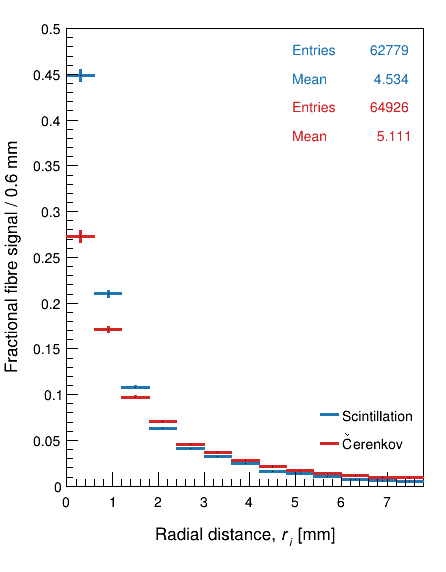

In [42]:
c8 = ROOT.TCanvas("c8", "c8", 450, 600)
ROOT.gStyle.SetOptStat("em")
x = ["Scnt_r_mm", "Ckov_r_mm"]
y = ["Scnt_norm", "Ckov_norm"]
p = [None, None]
model = ("", "", nbins, xlow, xup)
p[0] = rdf_profile['10GeV'].Profile1D(model, x[0], y[0])
p[1] = rdf_profile['40GeV'].Profile1D(model, x[1], y[1])
p[0].Draw()
p[1].Draw("sames")

#
p[0].SetLineColor(palette['blue'].GetNumber())
p[1].SetLineColor(palette['red'].GetNumber())
p[0].GetXaxis().SetTitle("Radial distance, #it{r_{i}} [mm]")
p[0].GetXaxis().SetRangeUser(0., 7.8)
p[0].GetYaxis().SetTitle(f"Fractional fibre signal / {binwidth} mm")
p[0].SetAxisRange(0., 0.5, "Y")

#
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetBottomMargin(0.15)
ROOT.gPad.SetRightMargin(0.05)
ROOT.gPad.SetTopMargin(0.05)

labelsize = 1 * p[0].GetYaxis().GetLabelSize()
titlesize = 1.2 * p[0].GetYaxis().GetTitleSize()
xtitleoffset = 1.3 * p[0].GetXaxis().GetTitleOffset()
ytitleoffset = 1.4 * xtitleoffset
xlabeloffset = 2 * p[0].GetXaxis().GetLabelOffset()
ylabeloffset = 2 * p[0].GetYaxis().GetLabelOffset()
linewidth = 3
# x2ndc = 0.89+0.08
# y2ndc = 0.88+0.05

ticklength = 0.02
x2ndc = 1-0.05-0.01
y2ndc = 1-0.05-0.012

p[0].SetLineWidth(linewidth)
p[1].SetLineWidth(linewidth)

p[0].GetXaxis().SetTitleSize(titlesize)
p[0].GetXaxis().SetLabelSize(labelsize)
p[0].GetXaxis().CenterTitle()
p[0].GetXaxis().SetTitleOffset(xtitleoffset)
p[0].GetXaxis().SetLabelOffset(xlabeloffset)

p[0].GetYaxis().SetTitleSize(titlesize)
p[0].GetYaxis().SetLabelSize(labelsize)
p[0].GetYaxis().CenterTitle()
p[0].GetYaxis().SetTitleOffset(ytitleoffset)
p[0].GetYaxis().SetLabelOffset(ylabeloffset)

c8.Update()

# stat box
stats1 = p[0].GetListOfFunctions().FindObject("stats")
p[0].GetListOfFunctions().Remove(stats1)
p[0].SetStats(0)
stats1.GetLineWith("Mean y").SetTextColor(0)
stats1.SetTextColor(palette['blue'].GetNumber())
stats1.SetX2NDC(x2ndc)
stats1.SetY2NDC(y2ndc)
stats1.SetX1NDC(stats1.GetX2NDC()-0.3)
stats1.SetY1NDC(stats1.GetY2NDC()-0.1)
stats1.SetTextSize(labelsize)
stats1.SetBorderSize(0)
stats1.GetListOfLines().Remove(stats1.GetLineWith("Mean y"))
stats1.Draw()
p[0].SetStats(0)

stats2 = p[1].GetListOfFunctions().FindObject("stats")
p[1].GetListOfFunctions().Remove(stats2)
p[1].SetStats(0)
stats2.SetTextColor(palette['red'].GetNumber())
stats2.SetX2NDC(stats1.GetX2NDC())
stats2.SetY2NDC(stats1.GetY1NDC())
stats2.SetX1NDC(stats1.GetX1NDC())
stats2.SetY1NDC(stats1.GetY1NDC()-0.1)
stats2.SetTextSize(labelsize)
stats2.SetBorderSize(0)
stats2.GetListOfLines().Remove(stats2.GetLineWith("Mean y"))
stats2.Draw()
p[1].SetStats(0)

# legend
legend = ROOT.TLegend(stats1.GetX1NDC()+0.07, 0.2, stats1.GetX2NDC(), 0.3)
legend.SetFillColor(0)
#legend.SetTextAlign(ROOT.kHAlignLeft+ROOT.kVAlignTop)
legend.SetBorderSize(0)
legend.SetTextSize(labelsize)
legend.AddEntry(p[0].GetValue(), "Scintillation", "l")
legend.AddEntry(p[1].GetValue(), "#check{C}erenkov", "l")
legend.Draw()

c8.Modified()

c8.Update()
c8.Draw()
c8.SaveAs("LateralProfile.png")